

<p align="center"><center>
  <img width="800" height="800" src="https://generalposte.com/wp-content/uploads/2020/01/vtc.jpg">
    </center></p>
    
#  <span style="color:"><center>**UBER**</center></span>

La problématique rencontrée par l'équipe d'Uber découle du constat suivant : les chauffeurs ne sont pas présents dans les zones ou les utilisateurs ont un besoin. 
Par exemple, un utilisateur peut se trouver dans le quartier financier de San Francisco alors que les chauffeurs Uber recherchent des clients à Castro.

Par conséquent, l'équipe de données d'Uber aimerait travailler sur un projet dans lequel son application recommanderait des zones chaudes dans les grandes villes à n'importe quel moment de la journée.

Pour cela nous allons utiliser différentes méthodes de clustering afin de déterminer les zones chaudes.

In [1]:
!pip install plotly -q
!pip install missingno -q
import plotly.graph_objects as go
import pandas as pd 
import numpy as np
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
uber_avril = pd.read_csv('uber-raw-data-apr14.csv')
uber_mai = pd.read_csv('uber-raw-data-may14.csv')
uber_juin = pd.read_csv('uber-raw-data-jun14.csv')
uber_juillet = pd.read_csv ('uber-raw-data-jul14.csv')
uber_aout = pd.read_csv ('uber-raw-data-aug14.csv')
uber_septembre = pd.read_csv ('uber-raw-data-sep14.csv')
uber_taxi_zone = pd.read_csv ('taxi-zone-lookup.csv')

data = uber_avril.append([uber_mai,uber_juin,uber_juillet,uber_aout,uber_septembre], ignore_index=True)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764


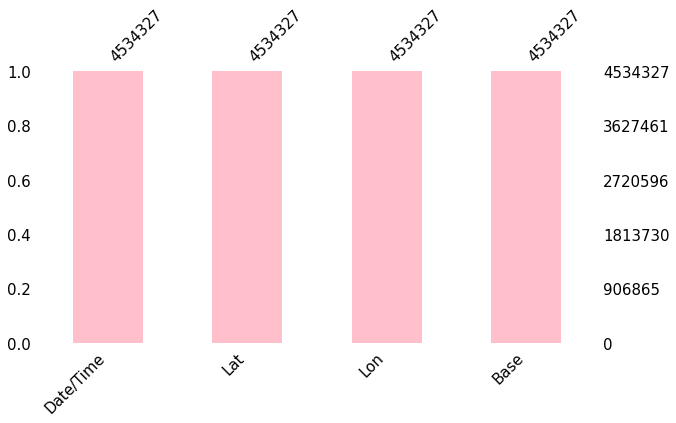

In [3]:
msno.bar(data,figsize=(10, 5),fontsize=15,color='pink');
data

On constate que nous avons un jeu de données propres, il n'a aucune donnée manquante.

In [4]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data['semaine'] =pd.to_datetime(data['Date/Time']).dt.isocalendar().week
data['jours'] =pd.to_datetime(data['Date/Time']).dt.isocalendar().day
data['jour_semaine']=pd.to_datetime(data['Date/Time']).dt.weekday
#data['année'] = pd.to_datetime(data['Date/Time']).dt.isocalendar().year
data['mois'] = pd.to_datetime(data['Date/Time']).dt.month
#data['true_date'] = pd.to_datetime(data['Date/Time'])
#data['true_date'].sort_values()
data[['heure','minutes']] = pd.DataFrame([(x.hour, x.minute) for x in data['Date/Time']])

# KMeans

Nos données sont réparties dans la zone géographique de New York, il y a donc une distance euclidienne.

Nous sommes donc capables d'utiliser la méthode K-Means qui est une technique qui sépare les observations par clusters où chaque observation est considérée comme appartenant à un groupe où la moyenne est la plus proche selon une distance donnée.

Pour savoir le nombre de clusters nous allons utiliser la méthode du coude, et de la silhouette.

In [5]:
#mask = (data['mois'] == 6) & (data['heure'] >=16)
#features_list = ["Lat","Lon"]
#X = data.loc[mask,features_list].sample(n=1000)
masq = ((data['mois'] == 6) & (data['semaine'] == 23) & (data['heure'] >=16))
features_list = ["Lat","Lon"]
X = data.loc[masq,features_list].sample(n=10000)
#sc = StandardScaler()# Standard scaler transform X as numpy array.
#X = sc.fit_transform(X)

wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    #print("WCSS for K={} --> {}".format(i, wcss[-1]))

# Create DataFrame, Create figure
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia par cluster"
)
fig.show(renderer="iframe") 

#Attention, il faut commencer à i=2 car le score silhouette 
#ne peut accepter moins de 2 labels
sil = []
k = []
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    #print("Silhouette score for K={} is {}".format(i, sil[-1]))
    

#Create a data frame,Create figure
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score par cluster"
)
fig.show(renderer="iframe") # if using workspace



#Appliquons maintenant K-Means sur notre jeu de données .
kmeans = KMeans(n_clusters=5, random_state=0, init="k-means++")

# Fit kmeans to our dataset
kmeans.fit(X)

clusters = kmeans.predict(X)
centroïde = kmeans.cluster_centers_

X['clusters']= kmeans.labels_
X['jours'] = data['jours']
X['heure'] = data['heure']


WCSS for K=1 --> 45.90883720111868
WCSS for K=2 --> 25.872258870096207
WCSS for K=3 --> 19.654725260472205
WCSS for K=4 --> 15.054864625593648
WCSS for K=5 --> 11.050317382432427
WCSS for K=6 --> 9.087253436717976
WCSS for K=7 --> 7.703222605969345
WCSS for K=8 --> 6.76521482473733
WCSS for K=9 --> 5.801949032078732
WCSS for K=10 --> 5.287521481013788


Silhouette score for K=2 is 0.7428745175360846
Silhouette score for K=3 is 0.39431646837625794
Silhouette score for K=4 is 0.4145506156352023
Silhouette score for K=5 is 0.44138551010344607
Silhouette score for K=6 is 0.4716994286602172
Silhouette score for K=7 is 0.4762299659886086
Silhouette score for K=8 is 0.47908028455288004
Silhouette score for K=9 is 0.4635199611635023
Silhouette score for K=10 is 0.4747688506463981


Bien que les deux méthodes essaient de déterminer dans quelle mesure nos données sont bien divisées, elles proposent deux approches opposées.

La méthode du coude essaie de voir si chaque point de données d'un cluster sont proches les uns des autres .
La Silhouette essaie de déterminer à quelle distance se trouve chaque groupe (et donc à quel point ils sont significatifs).

Grâce à c'est deux méthodes nous sommes maintenant en mesure de définir le nombre de clusters qui est de 5.

In [6]:
fig = px.scatter_mapbox(X.sort_values(by =['jours']),
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'jours',
                        animation_group = 'heure',                
                        color="clusters",
                        mapbox_style = "carto-positron",
                        zoom=9,
                        title = '')
fig.show(renderer="iframe")

In [7]:
fig = px.scatter_mapbox(X.sort_values(by =['heure']),
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'heure',
                        animation_group = 'heure',                
                        color="clusters",
                        mapbox_style = "carto-positron",
                        zoom=9,
                        title = '')
fig.show(renderer="iframe")

Maintenant nous pouvons visualiser les données de notre modèle K-means on peut voir qu'il a divisé un ensemble de données en différents « paquets » homogènes en fonction de K.

5 clusters ont été définis avec un nombre de point très dense dans le nord et le sud de MANHATTAN ( cluster 0 et 2 ) à n'importe quel jours/heure de la semaine entraînant une demande constante de chauffeurs.
En revanche, les aéroports ont des variations en fonction de l'heure et du jour entraînant une forte demande  le lundi, samedi et dimanche entre 16h et 18h. 
On constate cependant que certains clusters ne nécessitent pas une présence accrue des chauffeurs car la demande semble moins importante (cluster 3).

Il est donc préférable de planifier une grosse flottes de véhicules sur les points stratégiques ( cluster 0 ; 2; 4 )comme le centre de New York ou la demande est constante mais également sur les aéroports en fonction des pîques d'affluence.

En conclusion, on peut différencier deux variables permettant d'ajuster la flotte Uber de façon efficiente.
- une demande constante (cluster 0;2;4)
- une saisonnalité liée au pîque d'affluence (cluster 1;3)


# DBSCAN

L’algorithme DBSCAN utilise 2 paramètres : la distance epsilon (une distance physique de chaque point) et le nombre minimum de points “min_sample” (taille de cluster minimale) devant se trouver dans un rayon epsilon pour que ces points soient considérés comme un cluster.

Nous utiliserons la métric "manhattan" qui est plus à même de répondre à nos besoins qui place 2 points sur le sommet diagonal d'un carré et prend la distance égale à la moitié du périmètre.
Contrairement à la métric "euclidienne" qui coupe en diagonale un bâtiment à un autre elle nous donnerait une estimation réaliste.

Cette méthode est parfaite pour les données spatiales latitude-longitude.


In [8]:
# import DBSCAN from sklearn and numpy
from sklearn.cluster import DBSCAN
import numpy as np
mask = ((data['mois'] == 6) & (data['semaine'] == 23) & (data['heure'] >=16))
features = ["Lat","Lon"]
x = data.loc[mask,features]#.sample(n=10000)
# Instanciate DBSCAN 
db = DBSCAN(eps=0.0008, min_samples=150, metric="manhattan", algorithm="brute")

# Fit on data 
## No need to normalize data, it already is! 
db.fit(x)
x["cluster"] = db.labels_
x['jours'] = data['jours']
x['heure'] = data['heure']

labels = db.labels_
unique_lab = set(x["cluster"])
nombre_cluster = len(unique_lab)
n_noise_ = list(labels).count(-1)


print(f'Nombres de clusters:{nombre_cluster}')
print((f'Nombres de bruits:{n_noise_}'))
fig = px.scatter_mapbox(x.sort_values(by =['jours'])[x.cluster != -1],
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'jours',
                        animation_group = 'jours',                
                        color="cluster",
                        mapbox_style = "carto-darkmatter",
                        zoom=9.5,
                        title = '')
fig.show(renderer="iframe")

Nombres de clusters:27
Nombres de bruits:65212


<ipython-input-8-e144935fbb4e>:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [9]:
fig = px.scatter_mapbox(x.sort_values(by =['heure'])[x.cluster != -1],
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'heure',
                        animation_group = 'heure',                
                        color="cluster",
                        mapbox_style = "carto-darkmatter",
                        zoom=9.5,
                        title = '')
fig.show(renderer="iframe")

<ipython-input-9-8167dd2d85e7>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Pour DBSCAN, nous ne pouvons pas définir le nombre de clusters attendu en paramètre
car l'algorithme essaie de trouver lui-même le nombre de clusters.

il crée des clusters de plus forte densitée et catégorise les points non clusterisé comme du bruit qui sont représentés comme des outliers.

l'algorythme a permis d'affiner nos résultats du modèle K-MEANS en conservant les données les plus fiables pour orienter le choix de répartition des chauffeurs sur les différents lieux stratégiques tels que les aéroports et le centre de Manhattan.

# Conclusion

le model K-Means a permit d'identifier 5 clusters en mettant en évidence les différentes zones chaudes,
comme le sud et le nord de Manhattan qui représentent des clusters denses ou encore Newark, Steinway, Brookklyn qui correspondent à d'autres clusters ou les points sont moins concentrés.
Du lundi au vendredi, les demandes se font plus importantes à Manhattan tandis qu'en fin de semaine elles changent et se déplacent plus au nord de Harlem, Brooklyn avec un creux à 20H et 22h pour les aéroports.

DBSCAN a mis en évidence nos données de façon concentrées et nous a permis de déterminer l'emplacement exact ou devrait se placer les chauffeurs Uber afin de répondre au mieux aux attentes des clients et limiter au maximum le temps d'attente comme les aéroports, Le Grand Army Plaza , Meatpacking District, le Theater District, Midtown et Midtown EST.

Pour finir, le model DBSCAN permettra à Uber de placer ses véhicules de façon stratégique en complémentarité avec le model K-means, qui lui indiquera les zones chaudes à couvrir par les chauffeurs pour satisfaire au maximum la demande.